# Generating a report that monitors research topics across Dimensions sources

This notebook shows how to create a simple that can be run periodically, for example in order to monitor a research area. 

By using the steps below it is possible to generate API queries programmatically, based on a predefined list of parameters (eg keywords, years, or fields of research). We will then run these queries on all Dimensions [data sources](https://docs.dimensions.ai/dsl/data-sources.html) (publications, grants, clinical trials, patents, policy documentes and datasets). 

The resulting dataset provides a snapshot of how much content is available in Dimensions on the selected topic.  

> **IMPORTANT** The notebook is best experienced with [Google Colab](https://colab.research.google.com/), as it includes a number of Colab-only user interface widgets. 

In [2]:
import datetime
print("==\nCHANGELOG\nThis notebook was last run on %s\n==" % datetime.date.today().strftime('%b %d, %Y'))

==
CHANGELOG
This notebook was last run on Jan 24, 2022
==


## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the ['Getting Started' tutorial](https://api-lab.dimensions.ai/cookbooks/1-getting-started/1-Using-the-Dimcli-library-to-query-the-API.html).

In [3]:
!pip install dimcli tqdm plotly -U --quiet 

import dimcli
from dimcli.utils import *

import sys, time, json
import pandas as pd
from tqdm.notebook import tqdm as progressbar

import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login(key=KEY, endpoint=ENDPOINT)
dsl = dimcli.Dsl()

Searching config file credentials for 'https://app.dimensions.ai' endpoint..


==
Logging in..
Dimcli - Dimensions API Client (v0.9.6)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.0
Method: dsl.ini file


## 1. Creating a query builder 

We are going to create a series of input fields that allow to generate a query like this:

`search <source-name> for "<topic1 AND topic2>" where year=<YYYY> return <source-name>` 

The idea is to generate programmatically one query per year and Dimensions content type, so to extract some useful statistics about the 'popularity' of a topic. 

In [4]:
#@title Enter a Search Term

search_term = "\"peanut allergy\" AND children"  #@param {type: "string"}
#@markdown ---
start_year = 2006  #@param {type: "slider", min: 1900, max: 2020}
end_year = 2020  #@param {type: "slider", min: 1900, max: 2020}
#@markdown ---
subject_area = "None"  #@param ['None', '0101 Pure Mathematics', '0102 Applied Mathematics', '0103 Numerical and Computational Mathematics', '0104 Statistics', '0105 Mathematical Physics', '0201 Astronomical and Space Sciences', '0202 Atomic, Molecular, Nuclear, Particle and Plasma Physics', '0203 Classical Physics', '0204 Condensed Matter Physics', '0205 Optical Physics', '0206 Quantum Physics', '0299 Other Physical Sciences', '0301 Analytical Chemistry', '0302 Inorganic Chemistry', '0303 Macromolecular and Materials Chemistry', '0304 Medicinal and Biomolecular Chemistry', '0305 Organic Chemistry', '0306 Physical Chemistry (incl. Structural)', '0307 Theoretical and Computational Chemistry', '0399 Other Chemical Sciences', '0401 Atmospheric Sciences', '0402 Geochemistry', '0403 Geology', '0404 Geophysics', '0405 Oceanography', '0406 Physical Geography and Environmental Geoscience', '0499 Other Earth Sciences', '0501 Ecological Applications', '0502 Environmental Science and Management', '0503 Soil Sciences', '0599 Other Environmental Sciences', '0601 Biochemistry and Cell Biology', '0602 Ecology', '0603 Evolutionary Biology', '0604 Genetics', '0605 Microbiology', '0606 Physiology', '0607 Plant Biology', '0608 Zoology', '0699 Other Biological Sciences', '0701 Agriculture, Land and Farm Management', '0702 Animal Production', '0703 Crop and Pasture Production', '0704 Fisheries Sciences', '0705 Forestry Sciences', '0706 Horticultural Production', '0707 Veterinary Sciences', '0799 Other Agricultural and Veterinary Sciences', '0801 Artificial Intelligence and Image Processing', '0802 Computation Theory and Mathematics', '0803 Computer Software', '0804 Data Format', '0805 Distributed Computing', '0806 Information Systems', '0807 Library and Information Studies', '0899 Other Information and Computing Sciences', '0901 Aerospace Engineering', '0902 Automotive Engineering', '0903 Biomedical Engineering', '0904 Chemical Engineering', '0905 Civil Engineering', '0906 Electrical and Electronic Engineering', '0907 Environmental Engineering', '0908 Food Sciences', '0909 Geomatic Engineering', '0910 Manufacturing Engineering', '0911 Maritime Engineering', '0912 Materials Engineering', '0913 Mechanical Engineering', '0914 Resources Engineering and Extractive Metallurgy', '0915 Interdisciplinary Engineering', '0999 Other Engineering', '1001 Agricultural Biotechnology', '1002 Environmental Biotechnology', '1003 Industrial Biotechnology', '1004 Medical Biotechnology', '1005 Communications Technologies', '1006 Computer Hardware', '1007 Nanotechnology', '1099 Other Technology', '1101 Medical Biochemistry and Metabolomics', '1102 Cardiorespiratory Medicine and Haematology', '1103 Clinical Sciences', '1104 Complementary and Alternative Medicine', '1105 Dentistry', '1106 Human Movement and Sports Science', '1107 Immunology', '1108 Medical Microbiology', '1109 Neurosciences', '1110 Nursing', '1111 Nutrition and Dietetics', '1112 Oncology and Carcinogenesis', '1113 Ophthalmology and Optometry', '1114 Paediatrics and Reproductive Medicine', '1115 Pharmacology and Pharmaceutical Sciences', '1116 Medical Physiology', '1117 Public Health and Health Services', '1199 Other Medical and Health Sciences', '1201 Architecture', '1202 Building', '1203 Design Practice and Management', '1205 Urban and Regional Planning', '1299 Other Built Environment and Design', '1301 Education Systems', '1302 Curriculum and Pedagogy', '1303 Specialist Studies In Education', '1399 Other Education', '1401 Economic Theory', '1402 Applied Economics', '1403 Econometrics', '1499 Other Economics', '1501 Accounting, Auditing and Accountability', '1502 Banking, Finance and Investment', '1503 Business and Management', '1504 Commercial Services', '1505 Marketing', '1506 Tourism', '1507 Transportation and Freight Services', '1601 Anthropology', '1602 Criminology', '1603 Demography', '1604 Human Geography', '1605 Policy and Administration', '1606 Political Science', '1607 Social Work', '1608 Sociology', '1699 Other Studies In Human Society', '1701 Psychology', '1702 Cognitive Sciences', '1799 Other Psychology and Cognitive Sciences', '1801 Law', '1899 Other Law and Legal Studies', '1901 Art Theory and Criticism', '1902 Film, Television and Digital Media', '1903 Journalism and Professional Writing', '1904 Performing Arts and Creative Writing', '1905 Visual Arts and Crafts', '1999 Other Studies In Creative Arts and Writing', '2001 Communication and Media Studies', '2002 Cultural Studies', '2003 Language Studies', '2004 Linguistics', '2005 Literary Studies', '2099 Other Language, Communication and Culture', '2101 Archaeology', '2102 Curatorial and Related Studies', '2103 Historical Studies', '2199 Other History and Archaeology', '2201 Applied Ethics', '2202 History and Philosophy of Specific Fields', '2203 Philosophy', '2204 Religion and Religious Studies', '2299 Other Philosophy and Religious Studies']
#@markdown ---

# note:  
# for subject areas, the dropdown can be generated with this line: 
# `str(["%s" % s for s in  sorted(dimcli.G.categories('category_for')) if len(s.split()[0]) > 2])`
#


#
# define query templates for each source
#

q_template_sources = {
    'clinical_trials' : 
      """search {} for \"{}\" where active_years={} {} return {} limit 1""",
    'grants' : 
      """search {} for \"{}\" where active_year={} {} return {} limit 1""",
    'patents' : 
      """search {} for \"{}\" where granted_year={} {} return {} limit 1""",
    'policy_documents' : 
      """search {} for \"{}\" where year={} {} return {} limit 1""", 
    'datasets' : 
      """search {} for \"{}\" where year={} {} return {} limit 1""", 
    'publications' : 
      """search {} for \"{}\" where year={} {} return {} limit 1"""
}

# fix Python escapes
keywords = search_term.replace("\"", "\\\"" )

# subject area query component
if subject_area == "None":
  subject_area_q = ""
else:
  subject_area_q = f""" and FOR.name="{subject_area}" """

# ensure end year is > start year and explode range
if end_year < start_year:
  end_year = start_year
years = range(start_year, end_year+1)

# finally print some info
print("====SELECTION====")
print("Search term:\n", search_term)
print("Years:\n", start_year, "to", end_year)
print("Subject:\n", subject_area or "--")
print("=================")
  

====SELECTION====
Search term:
 "peanut allergy" AND children
Years:
 2006 to 2020
Subject:
 None


### Query logic

In this section we use the parameters from the query builder form, so to generate API queries programmatically. Note:

* the `q_template_sources` mapping above is used to to generate a (slightly) different query for each Dimensions document type
* a different query is generated for each year (`years` variable)
* we pause for one second after each query (`time.sleep(1)`), to ensure we never hit the API quota (30 queries per minute)  

TIP: if the progress bar doesn't display correctly, just stop and restart the cell. 

In [5]:
# The next function runs a query against each Dimensions sources 

def multi_search(verbose=False):
  "Launch multiple keyword searches across DSL sources"
  
  results = []

  loop1 = progressbar(q_template_sources)
  loop2 = progressbar(years)

  for s in loop1:
    loop1.set_description("Source: %s" % s)
    q_template = q_template_sources[s]

    for y in loop2:
      loop2.set_description("Year: %d" % y)

      q = q_template.format(s, keywords, y, subject_area_q, s) 
      if verbose: print(q)

      data = dsl.query(q, verbose=False)

      results.append({'source' : s, 'objects' : data.count_total, 'year' : y, 'query' : q})
      time.sleep(1)

  return pd.DataFrame.from_dict(results)


print("Searching in document types:", list(q_template_sources.keys()))
df = multi_search(verbose=False) # tip: set verbose to True to see the API queries details
df

Searching in document types: ['clinical_trials', 'grants', 'patents', 'policy_documents', 'datasets', 'publications']


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

,source,objects,year,query
0,clinical_trials,4,2006,"search clinical_trials for ""\""peanut allergy\""..."
1,clinical_trials,6,2007,"search clinical_trials for ""\""peanut allergy\""..."
2,clinical_trials,11,2008,"search clinical_trials for ""\""peanut allergy\""..."
3,clinical_trials,14,2009,"search clinical_trials for ""\""peanut allergy\""..."
4,clinical_trials,19,2010,"search clinical_trials for ""\""peanut allergy\""..."
...,...,...,...,...
85,publications,1061,2016,"search publications for ""\""peanut allergy\"" AN..."
86,publications,1119,2017,"search publications for ""\""peanut allergy\"" AN..."
87,publications,1121,2018,"search publications for ""\""peanut allergy\"" AN..."
88,publications,1706,2019,"search publications for ""\""peanut allergy\"" AN..."


## 2. Plotting the results 

In this section we use [plotly](https://plotly.com/python/) in order to visualize the data we extracted. 

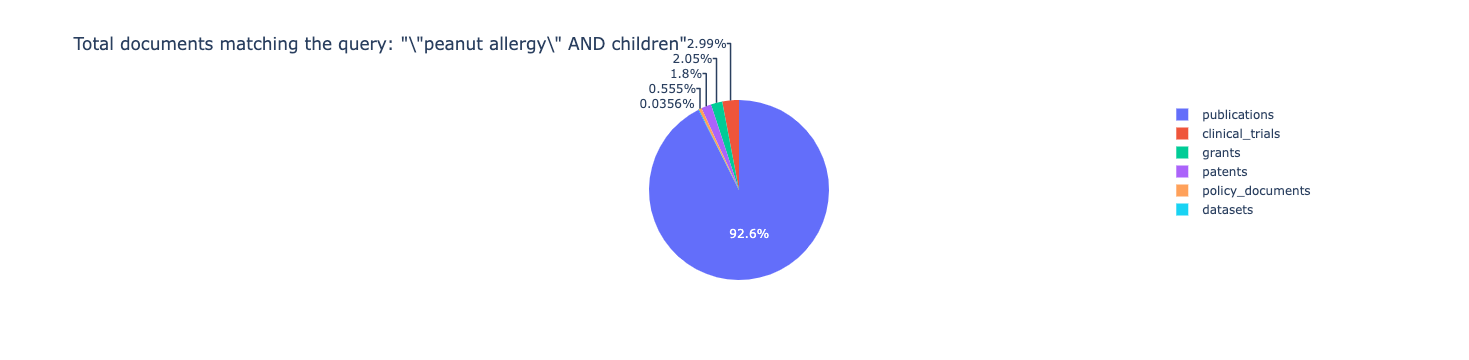

In [6]:
px.pie(df.groupby("source", as_index=False).sum(), 
       names="source", 
       values="objects", 
       title=f"Total documents matching the query: \"{keywords}\"")

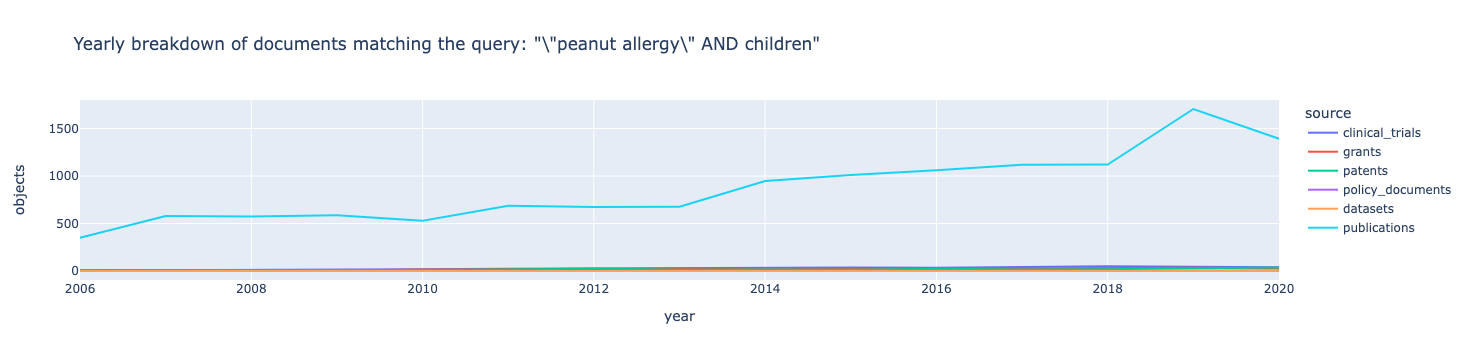

In [7]:
px.line(df, 
        x="year", 
        y="objects", 
        line_group="source",
        color="source", 
        title=f"Yearly breakdown of documents matching the query: \"{keywords}\"")


Tip: click on the legend on the right in order to hide/reveal specific sources. 

## 3. Conclusions

In this tutorial we have seen how to leverage Google Colab and Python functionalities in order to generate API queries programmatically. This approach makes it possible to create a simple report that can be run periodically, for example in order to monitor a research area. 

You can try changing the query templates in section 1 to carry out different kinds of analyses, for example: 

* to monitor differences in publications results, depending on whether one searches in the full text, title, or abstract (see the available [publications search indices](https://docs.dimensions.ai/dsl/datasource-publications.html#publications-search-indexes))
* to monitor differences in content volumes from different countries, organizations or funders 

For more information on what options are available, please see the [API documentation](https://docs.dimensions.ai/dsl/).